In [375]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric_temporal
import matplotlib.pyplot as plt
import torch.nn as nn
import random


print(torch.cuda.is_available())        # should print True
print(torch.version.cuda)               # should print 12.1
print(torch.cuda.get_device_name(0))    # should print GPU name

from torch_geometric.data import Data
from torch_geometric_temporal.signal import DynamicGraphStaticSignal
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal



True
12.1
NVIDIA GeForce GTX 960M


In [376]:
#-- importing the node and position link csv files --
base_dir = 'D:/Desktop/MSc Thesis - Copy/'

nodes_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/nodes_urban_feat.csv'), header = 0)
positions_links_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/positions_links.csv'), header = 0)


#-- adjusting some of the imported fields --
if 'geometry' in nodes_df.columns:
    nodes_df.drop(columns=['geometry'], inplace=True) #dropping the geometry column

for col in nodes_df.select_dtypes(include=['bool']).columns: # converting boolean columnkks to integers
    nodes_df[col] = nodes_df[col].astype(int)

# converting time stamps
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["merged_datetime"], format='ISO8601')                                                   
positions_links_df["merged_datetime"] = pd.to_datetime(positions_links_df['merged_datetime'], format='ISO8601').astype(int) // 10**9

# making sure ids are integers
positions_links_df['id_participant'].astype(int)
positions_links_df["node_id"] = positions_links_df["node_id"].astype(int)
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"].astype(int)
positions_links_df["id_participant"] = positions_links_df["id_participant"].astype(int)

# making the ids start from 0
nodes_df["id"] = nodes_df["node_id"] - 1
positions_links_df["node_id"] = positions_links_df["node_id"] - 1
positions_links_df["prev_node_id"] = positions_links_df["prev_node_id"] - 1
positions_links_df["id_participant"] = positions_links_df["id_participant"] - 1

In [377]:
# adding day and week time fields 
positions_links_df["hour_of_day"] = positions_links_df["timestamp"].dt.hour
positions_links_df["day_of_week"] = positions_links_df["day_of_week"] = positions_links_df["timestamp"].dt.dayofweek  # Monday=0 ... Sunday=6

In [378]:
# filtering the data to only include days with at least 10 active participants
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["timestamp"], utc=True).dt.tz_convert("Asia/Seoul")
positions_links_df["day"] = positions_links_df["timestamp"].dt.floor("D")
participant_counts_per_day = positions_links_df.groupby("day")["id_participant"].nunique()

active_days = participant_counts_per_day[participant_counts_per_day >= 10].index
excluded_days = participant_counts_per_day[participant_counts_per_day < 10].index
positions_links_df = positions_links_df[positions_links_df["day"].isin(active_days)]


print(f"Excluded days with fewer than 10 participants ({len(excluded_days)} days):")
for day in excluded_days:
    print(day.strftime('%Y-%m-%d'))


Excluded days with fewer than 10 participants (6 days):
2023-10-04
2023-10-05
2023-11-21
2023-11-22
2023-11-23
2023-11-24


In [379]:
# Ensure timestamp is sorted for each participant
positions_links_df = positions_links_df.sort_values(["id_participant", "timestamp"])

# Compute time differences for each participant
positions_links_df["time_diff"] = positions_links_df.groupby("id_participant")["timestamp"].diff().dt.total_seconds()

# 1. -- Overall Mean and Median Time Differences --
overall_mean = positions_links_df["time_diff"].mean(skipna=True)
overall_median = positions_links_df["time_diff"].median(skipna=True)

print("Overall:")
print(f"   Mean time difference:   {overall_mean:.2f} seconds")
print(f"   Median time difference: {overall_median:.2f} seconds")

# 2. -- Weekdays 09:00–18:00 Only --

# Apply time filter
mask = (positions_links_df["hour_of_day"] >= 9) & (positions_links_df["hour_of_day"] < 18) & (positions_links_df["day_of_week"] <= 4)
filtered_df = positions_links_df[mask]

# Recalculate time differences in the filtered set
filtered_df = filtered_df.sort_values(["id_participant", "timestamp"])
filtered_df["time_diff"] = filtered_df.groupby("id_participant")["timestamp"].diff().dt.total_seconds()

filtered_mean = filtered_df["time_diff"].mean(skipna=True)
filtered_median = filtered_df["time_diff"].median(skipna=True)

print("\nWeekdays (09:00–18:00):")
print(f"   Mean time difference:   {filtered_mean:.2f} seconds")
print(f"   Median time difference: {filtered_median:.2f} seconds")


Overall:
   Mean time difference:   5730.49 seconds
   Median time difference: 490.35 seconds

Weekdays (09:00–18:00):
   Mean time difference:   11707.35 seconds
   Median time difference: 1272.61 seconds


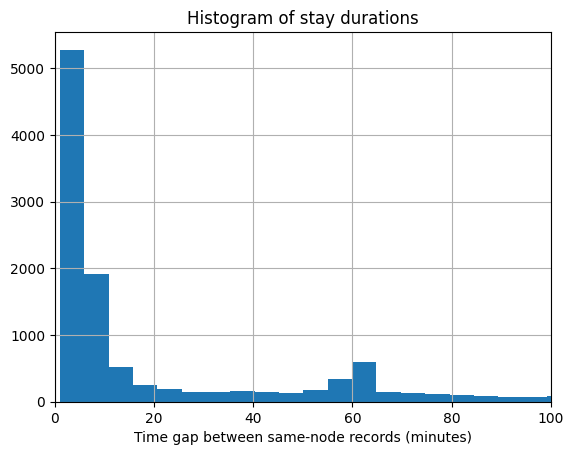

In [380]:
gaps = []

for pid, group in positions_links_df.groupby("id_participant"):
    group = group.sort_values("merged_datetime")
    stays = group[group["node_id"] == group["node_id"].shift()]
    delta = group["merged_datetime"].diff()
    gaps.extend(delta.dropna().values)

plt.hist(np.array(gaps) / 60, bins=1000)
plt.xlim(0, 100)
plt.xlabel("Time gap between same-node records (minutes)")
plt.title("Histogram of stay durations")
plt.grid()
plt.show()

In [381]:
# dealing with static positions (stays)


interval_stays = 60*60    # 60 minutes

# removing intermediate records of participants at the same node tbat are closer than the interval
def filter_redundant_stays(df, interval_sec):
    filtered_rows = []

    for pid, group in df.groupby("id_participant"):
        group = group.sort_values("merged_datetime")
        prev_node = None
        prev_time = None
        prev_row = None

        for i, row in group.iterrows():
            current_node = row["node_id"]
            current_time = row["merged_datetime"]

            if prev_node is None:
                filtered_rows.append(row)
                prev_time = current_time
                prev_node = current_node
                prev_row = row
                continue

            if current_node != prev_node:
                # ensuring last row at old node is saved
                if prev_row is not None and filtered_rows[-1]["merged_datetime"] != prev_row["merged_datetime"]:
                    filtered_rows.append(prev_row)
                # always adding first row at new node
                filtered_rows.append(row)
                prev_time = current_time
            elif (current_time - prev_time) >= interval_sec:
                # if the time difference is greater than the interval, add the row
                filtered_rows.append(row)
                prev_time = current_time

            prev_node = current_node
            prev_row = row
            
    print(f"Removed {len(df) - len(filtered_rows)} redundant stays.")
    print(f"Total rows before filtering: {len(df)}")
    print(f"Total rows after filtering: {len(filtered_rows)}")
    return pd.DataFrame(filtered_rows).sort_values(by="merged_datetime").reset_index(drop=True)

# adding new rows between stays to make it more consistent
def interpolate_static_positions(df, interval_sec):
    interpolated_rows = []
    new_count = 0

    for pid, group in df.groupby("id_participant"):
        group = group.sort_values("merged_datetime")
        prev_row = None

        for _, row in group.iterrows():
            if prev_row is None:
                interpolated_rows.append(row)
                prev_row = row
                continue

            same_node = row["node_id"] == prev_row["node_id"]
            t0 = prev_row["merged_datetime"]
            t1 = row["merged_datetime"]
            duration = t1 - t0

            if not same_node or duration <= interval_sec:           # rows where nothing is done
                interpolated_rows.append(row)
                prev_row = row
                continue

            n_steps = max(1, round(duration / interval_sec))

            for i in range(1, n_steps):
                frac = i / n_steps
                new_row = prev_row.copy()
                new_time = int(t0 + frac * (t1 - t0))
                new_row["merged_datetime"] = new_time
                new_row["timestamp"] = pd.to_datetime(new_time, unit='s').tz_localize("UTC").tz_convert("Asia/Seoul")
                new_row['hour_of_day'] = new_row["timestamp"].hour
                new_row['day_of_week'] = new_row["timestamp"].dayofweek
                new_row["day"] = new_row["timestamp"].floor("D")
                new_row["speed"] = 0
                new_row['interpolated'] = True
                #print(new_row["timestamp"])
                interpolated_rows.append(new_row)
                new_count += 1

            interpolated_rows.append(row)
            prev_row = row
    print(f"\nAdded {new_count} new rows for static positions.")
    print(f"Total rows before interpolation: {len(df)}")
    print(f"Total rows after interpolation: {len(interpolated_rows)}")
    print(f"Difference: {len(interpolated_rows)- len(df)}")
    return pd.DataFrame(interpolated_rows).sort_values(by="merged_datetime").reset_index(drop=True)
 
positions_links_df = filter_redundant_stays(positions_links_df, interval_stays)
positions_links_df = interpolate_static_positions(positions_links_df, interval_stays)

Removed 205 redundant stays.
Total rows before filtering: 13154
Total rows after filtering: 12949

Added 3178 new rows for static positions.
Total rows before interpolation: 12949
Total rows after interpolation: 16127
Difference: 3178


In [382]:
urban_features_to_use = ["GSI", "WMHB", "GrCR", "GD"] 
'''
using these urban feature:
- GSI: Ground Space Index
- WMHB: Area-Weighted Mean Height of Buildings
- GrCR: Green Cover Ratio
- GD: Distance to Green Space
'''

# normalizing the urban features to a range of 0 to 1
normalized = (nodes_df[urban_features_to_use] - nodes_df[urban_features_to_use].min()) / \
             (nodes_df[urban_features_to_use].max() - nodes_df[urban_features_to_use].min())

fill_values = {
    "GSI": 0.0,
    "FSI": 0.0,
    "OSR": 1.0,     # maximum open space
    "ABH": 0.0,
    "WMHB": 0.0,
    "HSTD": 0.0,
    "GrCR": 0.0,
    "GD": 1.0       # maximum distance (if normalized)
}

for col in urban_features_to_use:
    if col in fill_values:
        normalized[col] = normalized[col].fillna(fill_values[col])


urban_features_array = normalized.values

print(normalized.describe())


               GSI         WMHB         GrCR           GD
count  3774.000000  3774.000000  3774.000000  3774.000000
mean      0.260856     0.110188     0.075397     0.201739
std       0.136036     0.103362     0.159951     0.176990
min       0.000000     0.000000     0.000000     0.000000
25%       0.175975     0.054068     0.000000     0.059749
50%       0.281673     0.079365     0.000000     0.163149
75%       0.351742     0.135389     0.082095     0.292786
max       1.000000     1.000000     1.000000     1.000000


In [383]:
# dividing the data into time bins

interval = 60 * 60 * 2      # time bin interval = 2 
                            # only choosing intervals that divide 24 evenly [1h, 2h, 3h, 4h, 6h, 8h, 12h, 24h, etc.]
                            
# start_time = positions_links_df["merged_datetime"].min()
positions_links_df["timestamp"] = pd.to_datetime(positions_links_df["timestamp"], utc=True).dt.tz_convert("Asia/Seoul")
start_time_dt = positions_links_df["timestamp"].dt.floor("D").min()                     # aligning to midnight of the first day
start_time = int(start_time_dt.timestamp())                                             # timestamp in seconds           
end_time = positions_links_df["merged_datetime"].max()

positions_links_df['time_seconds'] = positions_links_df['merged_datetime'] - start_time         # time in seconds since the start
positions_links_df['time_bin'] = (positions_links_df["time_seconds"] // interval).astype(int)   # dividing them into time bins
participant_counts = positions_links_df.groupby("time_bin")["id_participant"].nunique()         # counting the number of participants in each time bin

In [384]:
print("Start time (datetime):", start_time_dt)
print("Start time (timestamp):", start_time)

Start time (datetime): 2023-10-06 00:00:00+09:00
Start time (timestamp): 1696518000


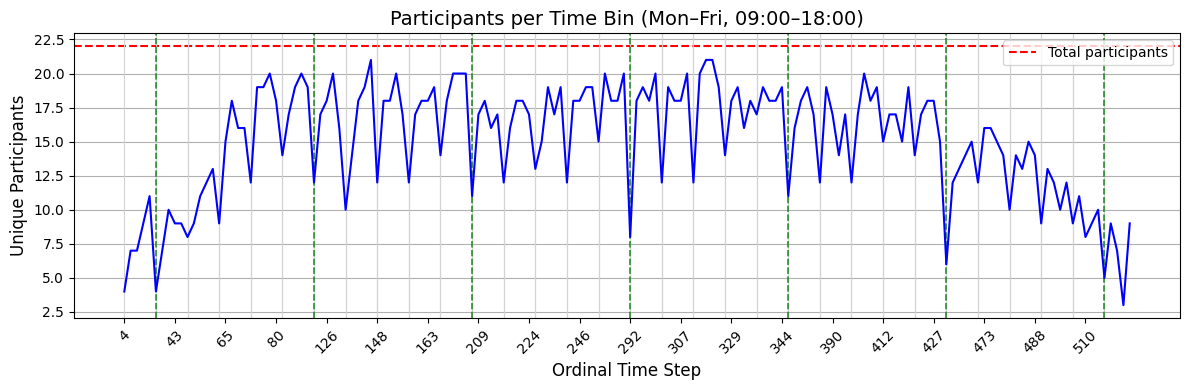

In [385]:
# plot to visualize how many participants are present per time bin (only between 09:00 and 18:00 and on weekdays)
plot_df = positions_links_df[
    (positions_links_df["hour_of_day"] >= 9) &
    (positions_links_df["hour_of_day"] < 18) &
    (positions_links_df["day_of_week"] <= 4)
]
participant_counts = plot_df.groupby("time_bin")["id_participant"].nunique()

x_positions = np.arange(len(participant_counts))
x_labels = participant_counts.index

plt.figure(figsize=(12, 4))
plt.axhline(positions_links_df["id_participant"].nunique(), color='red', linestyle='--', label='Total participants')

# Full set of bins and filtered set
all_bins = positions_links_df["time_bin"].unique()
all_bins = np.sort(all_bins)
included_bins = participant_counts.index
excluded_bins = np.setdiff1d(all_bins, included_bins)

# Map each bin to its weekday/hour (based on bin centers)
bin_hour_map = positions_links_df.groupby("time_bin")["hour_of_day"].first().to_dict()
bin_day_map = positions_links_df.groupby("time_bin")["day_of_week"].first().to_dict()

# Classify excluded bins
weekday_night_bins = []
weekend_bins = []

for b in excluded_bins:
    day = bin_day_map.get(b, None)
    hour = bin_hour_map.get(b, None)
    if day is None or hour is None:
        continue
    if day <= 4:  # Monday to Friday
        if hour < 9 or hour >= 18:
            weekday_night_bins.append(b)
    else:  # Saturday or Sunday
        weekend_bins.append(b)

# Map bin values to ordinal x positions (same as x_labels)
bin_to_x = {b: i for i, b in enumerate(included_bins)}

# Plot vertical lines for removed bins
for b in weekday_night_bins:
    if b in bin_to_x:
        continue  # don't draw if this bin was actually kept
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='lightgray', linestyle='-', linewidth=0.75, alpha =1)

for b in weekend_bins:
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=1.2, alpha=0.05)

plt.plot(x_positions, participant_counts.values, color='blue')

plt.xticks(x_positions[::max(len(x_positions)//20,1)], x_labels[::max(len(x_labels)//20,1)], rotation=45)
plt.title("Participants per Time Bin (Mon–Fri, 09:00–18:00)", fontsize=14)
plt.xlabel("Ordinal Time Step", fontsize=12)
plt.ylabel("Unique Participants", fontsize=12)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

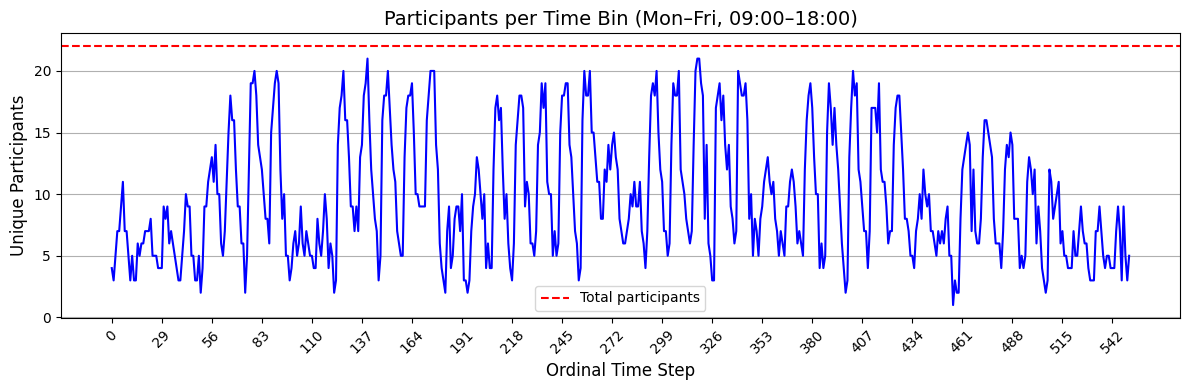

In [386]:
# plot to visualize how many participants are present per time bin (only between 09:00 and 18:00 and on weekdays)
plot_df = positions_links_df
participant_counts = plot_df.groupby("time_bin")["id_participant"].nunique()

x_positions = np.arange(len(participant_counts))
x_labels = participant_counts.index

plt.figure(figsize=(12, 4))
plt.axhline(positions_links_df["id_participant"].nunique(), color='red', linestyle='--', label='Total participants')

# Full set of bins and filtered set
all_bins = positions_links_df["time_bin"].unique()
all_bins = np.sort(all_bins)
included_bins = participant_counts.index
excluded_bins = np.setdiff1d(all_bins, included_bins)

# Map each bin to its weekday/hour (based on bin centers)
bin_hour_map = positions_links_df.groupby("time_bin")["hour_of_day"].first().to_dict()
bin_day_map = positions_links_df.groupby("time_bin")["day_of_week"].first().to_dict()

# Classify excluded bins
weekday_night_bins = []
weekend_bins = []

for b in excluded_bins:
    day = bin_day_map.get(b, None)
    hour = bin_hour_map.get(b, None)
    if day is None or hour is None:
        continue
    if day <= 4:  # Monday to Friday
        if hour < 9 or hour >= 18:
            weekday_night_bins.append(b)
    else:  # Saturday or Sunday
        weekend_bins.append(b)

# Map bin values to ordinal x positions (same as x_labels)
bin_to_x = {b: i for i, b in enumerate(included_bins)}

# Plot vertical lines for removed bins
for b in weekday_night_bins:
    if b in bin_to_x:
        continue  # don't draw if this bin was actually kept
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='lightgray', linestyle='-', linewidth=0.75, alpha =1)

for b in weekend_bins:
    idx = np.searchsorted(included_bins, b)
    if 0 <= idx < len(x_positions):
        plt.axvline(x=idx, color='green', linestyle='--', linewidth=1.2, alpha=0.05)

plt.plot(x_positions, participant_counts.values, color='blue')

plt.xticks(x_positions[::max(len(x_positions)//20,1)], x_labels[::max(len(x_labels)//20,1)], rotation=45)
plt.title("Participants per Time Bin (Mon–Fri, 09:00–18:00)", fontsize=14)
plt.xlabel("Ordinal Time Step", fontsize=12)
plt.ylabel("Unique Participants", fontsize=12)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [387]:
print(len(all_bins))
print (612/12)

550
51.0


In [388]:
# normalizing edge features

positions_links_df["hour_norm"] = positions_links_df["hour_of_day"] / 23.0     # hours: 0–23
positions_links_df["day_norm"] = positions_links_df["day_of_week"] / 6.0       # days: 0–6

speed_min = positions_links_df["speed"].min()
speed_max = positions_links_df["speed"].max()
positions_links_df["speed_norm"] = (positions_links_df["speed"] - speed_min) / (speed_max - speed_min)

In [389]:
# making the node features

coords = nodes_df[['node_x', 'node_y']].values
coords_min = coords.min(axis=0)
coords_max = coords.max(axis=0)
normalized_coords = (coords - coords_min) / (coords_max - coords_min)  # normalizing coordinates to [0, 1]

binary_features = nodes_df[['Indoors', 'in_Seoul']].values

node_feature_array = np.hstack([normalized_coords, binary_features, urban_features_array])
node_features = torch.tensor(node_feature_array, dtype=torch.float)

In [390]:
def classify_transport_mode(speed):
    speed = speed * (speed_max - speed_min) + speed_min  # denormalizing the speed
    if speed <= 7.5:    # meters per second
        return 0        # Personal mobility (walking, biking, etc)
    else:
        return 1        # Motorized mobility (car, metro, etc.)

In [391]:
# static edge list: all movement links between nodes
static_edges = positions_links_df[["prev_node_id", "node_id"]].dropna()
static_edges = static_edges.astype(int)
static_edge_index = torch.tensor(static_edges.drop_duplicates().values.T, dtype=torch.long)

features = []
edge_indices = []
edge_weights = []
targets = []
edge_features = []

num_nodes = nodes_df["id"].nunique()
min_time_between_counts = 30 * 60  # 30 minutes in seconds

#min_bin = int(positions_links_df['time_bin'].min())
min_bin = 0
max_bin = int(positions_links_df['time_bin'].max())
all_time_bins = range(min_bin, max_bin + 1)

bin_context = {}

for t in all_time_bins:
    df_now = positions_links_df[positions_links_df['time_bin'] == t].copy()
    df_next = positions_links_df[positions_links_df['time_bin'] == t + 1].copy()

    # ─── BIN CONTEXT ─────────────────────────────────────────────
    bin_start = start_time_dt + pd.Timedelta(seconds=interval * t)
    bin_midpoint = bin_start + pd.Timedelta(seconds=interval // 2)

    avg_hour = bin_midpoint.hour + bin_midpoint.minute / 60
    day_of_week = bin_midpoint.dayofweek

    hour_norm = avg_hour / 23.0
    day_norm = day_of_week / 6.0

    bin_context[t] = (hour_norm, day_norm)

    # ─── NODE FEATURES ───────────────────────────────────────────
    visit_df = df_now.groupby("node_id").size()
    visit_counts = visit_df.reindex(range(num_nodes), fill_value=0).values
    visit_tensor = torch.tensor(visit_counts, dtype=torch.float).unsqueeze(1)

    full_node_features = torch.cat([visit_tensor, node_features], dim=1)
    features.append(full_node_features)

    # ─── EDGE FEATURES ───────────────────────────────────────────
    if not df_now.empty:
        grouped = df_now.groupby(["prev_node_id", "node_id"]).agg({
            "hour_norm": "mean",
            "day_norm": "mean",
            "speed_norm": "mean",
            "id_participant": "count"  # this is flow
        }).rename(columns={"id_participant": "flow"}).reset_index()

        grouped["transport"] = grouped["speed_norm"].apply(classify_transport_mode)

        source = torch.tensor(grouped["prev_node_id"].values, dtype=torch.long)
        destination = torch.tensor(grouped["node_id"].values, dtype=torch.long)
        edge_index = torch.stack([source, destination], dim=0)

        edge_feat = torch.tensor(grouped[["hour_norm", "day_norm", "flow", "transport"]].values, dtype=torch.float)
        edge_weight = torch.ones(edge_index.size(1))
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_feat = torch.empty((0, 4), dtype=torch.float)
        edge_weight = torch.empty((0,))

    edge_indices.append(edge_index)
    edge_weights.append(edge_weight)
    edge_features.append(edge_feat)

    # ─── NODE TARGETS (filtered with same logic) ────────────────
    if df_next.empty:
        node_target = torch.zeros(num_nodes)
    else:
        visit_df = df_next.groupby("node_id").size()
        visit_counts = visit_df.reindex(range(num_nodes), fill_value=0).values
        node_target = torch.tensor(visit_counts, dtype=torch.float)

    # ─── EDGE TARGETS (raw from df_next, not filtered) ──────────
    if df_next.empty:
        flow_target = torch.empty((0,))
        next_edge_index = torch.empty((2, 0), dtype=torch.long)
        transport_target = torch.empty((0,), dtype=torch.long)
        edge_feat_target = torch.empty((0, 3), dtype=torch.float)
    else:
        grouped_next = df_next.groupby(["prev_node_id", "node_id"]).agg({
            "speed_norm": "mean",
            "hour_norm": "mean",
            "day_norm": "mean",
            "id_participant": "count"  # This is flow
        }).rename(columns={"id_participant": "flow"}).reset_index()

        grouped_next["transport"] = grouped_next["speed_norm"].apply(classify_transport_mode)

        next_source_node = torch.tensor(grouped_next["prev_node_id"].values, dtype=torch.long)
        next_destination_node = torch.tensor(grouped_next["node_id"].values, dtype=torch.long)
        next_edge_index = torch.stack([next_source_node, next_destination_node], dim=0)

        flow_target = torch.tensor(grouped_next["speed_norm"].values, dtype=torch.float)
        transport_target = torch.tensor(grouped_next["transport"].values, dtype=torch.long)
        edge_feat_target = torch.tensor(
            grouped_next[["hour_norm", "day_norm"]].values,
            dtype=torch.float
        )

    targets.append((node_target, next_edge_index, flow_target, transport_target, edge_feat_target))

In [392]:
graph_snapshots = []

for t in all_time_bins:
    snapshot = {
        "x": features[t],                         # Node features
        "edge_index": edge_indices[t],            # Edge indices
        "edge_weight": edge_weights[t],           # Edge weights (unused for now)
        "edge_feat": edge_features[t],            # Edge features (speed_norm, hour_norm, day_norm)
        "target_node": targets[t][0],             # Node-level target
        "target_edge_index": targets[t][1],       # Edges to predict speed for
        "target_edge_speed": targets[t][2],       # Edge-level speed prediction
    }
    graph_snapshots.append(snapshot)

In [393]:
t = 32  # Choose any valid time step

snapshot = features[t]             # Node features
edge_index = edge_indices[t]
edge_weight = edge_weights[t]
edge_feat = edge_features[t]

node_target, edge_index_target, flow_target, transport_target, edge_feat_target = targets[t]

print("Time Step:", t)
print("Node features shape:", snapshot.shape)               # [num_nodes, in_channels]
print("Edge index shape:", edge_index.shape)                # [2, num_edges]
print("Edge weight shape:", edge_weight.shape)              # [num_edges]
print("Edge feature shape:", edge_feat.shape)               # [num_edges, edge_feat_dim]
print("Node target shape:", node_target.shape)              # [num_nodes]
print("Target edge index shape:", edge_index_target.shape)  # [2, num_target_edges]
print("Target edge values shape:", flow_target.shape)       # [num_target_edges]

print("\n First 5 node features:\n", snapshot[:5])
print("\n First 5 edge features:\n", edge_feat[:5])
print("\n First 5 node targets:\n", node_target[:5])
print("\n First 5 target edges:\n", edge_index_target[:, :5])
print("\n First 5 target edge values:\n", flow_target[:5])
print("\n First 5 target transport values:\n", transport_target[:5])

Time Step: 32
Node features shape: torch.Size([3774, 9])
Edge index shape: torch.Size([2, 20])
Edge weight shape: torch.Size([20])
Edge feature shape: torch.Size([20, 4])
Node target shape: torch.Size([3774])
Target edge index shape: torch.Size([2, 24])
Target edge values shape: torch.Size([24])

 First 5 node features:
 tensor([[2.0000, 1.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.8536, 0.8536, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.1464, 0.8536, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

 First 5 edge features:
 tensor([[0.7174, 1.0000, 2.0000, 0.0000],
        [0.7174, 1.0000, 2.0000, 0.0000],
        [0.7391, 1.0000, 1.0000, 0.0000],
        [0.6957, 1.0000, 1.0000, 0.0000],
        [0.7174, 1.0000, 2.0000, 0.0000]])

 First 5 node targets:
 tens

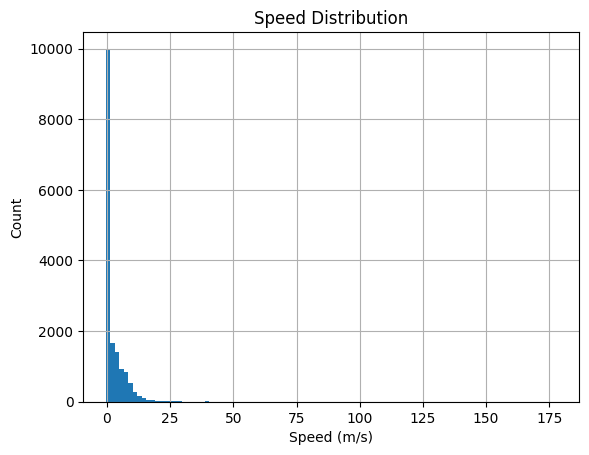

In [394]:
plt.hist(positions_links_df["speed"], bins=100)
plt.xlabel("Speed (m/s)")
plt.ylabel("Count")
plt.title("Speed Distribution")
plt.grid()
plt.show()

In [395]:
from torch_geometric.nn import NNConv
from torch.nn import GRUCell, Linear, ReLU, Sequential

class EdgeAwareTemporalEncoder(nn.Module):
    def __init__(self, in_channels, edge_feat_dim, hidden_dim):
        super().__init__()

        # edge-conditioned MLP to produce weights for each edge
        self.edge_nn = Sequential(
            Linear(edge_feat_dim, 32),
            ReLU(),
            Linear(32, in_channels * hidden_dim)
        )

        # NNConv does edge-conditioned message passing
        self.conv = NNConv(
            in_channels=in_channels,
            out_channels=hidden_dim,
            nn=self.edge_nn,
            aggr='mean'
        )

        # GRU maintains temporal state across time steps
        self.gru = GRUCell(hidden_dim, hidden_dim)

    def forward(self, x_seq, edge_index_seq, edge_attr_seq):
        h = None

        for x, edge_index, edge_attr in zip(x_seq, edge_index_seq, edge_attr_seq):
            out = self.conv(x, edge_index, edge_attr)

            if h is None:
                h = out
            else:
                h = self.gru(out, h)

        return h

In [396]:
class MovementLinkPredictor(nn.Module):
    def __init__(self, in_channels, encoder_edge_feat_dim, time_feat_dim, hidden_dim):
        super().__init__()

        self.encoder = EdgeAwareTemporalEncoder(
            in_channels=in_channels,
            edge_feat_dim=encoder_edge_feat_dim,  # use 3 for encoder
            hidden_dim=hidden_dim
        )

        # node target prediction
        self.node_decoder = nn.Sequential(
            Linear(hidden_dim + time_feat_dim, 64), 
            ReLU(),
            Linear(64, 1),
        )

        self.edge_flow_decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim + time_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.transport_decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim + time_feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward_encoder(self, x_seq, edge_index_seq, edge_attr_seq):
        return self.encoder(x_seq, edge_index_seq, edge_attr_seq)

    def predict_node_counts(self, z, time_feat):
        combined = torch.cat([z, time_feat], dim=1)
        return self.node_decoder(combined).squeeze(1)

    def predict_edge_flow(self, z, edge_index, time_feat):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst, time_feat], dim=1)
        return self.edge_flow_decoder(combined).squeeze(1)

    def predict_edge_mode(self, z, edge_index, time_feat):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        combined = torch.cat([src, dst, time_feat], dim=1)
        return self.transport_decoder(combined)

In [397]:
# --- Time-Stratified Split ---
# def generate_stratified_split(all_bins, train_ratio=0.8, stride=3):
#     train_bins = all_bins[::stride]
#     test_bins = [b for b in all_bins if b not in train_bins]
#     cutoff = int(len(train_bins) * train_ratio)
#     return train_bins[:cutoff], test_bins

def generate_stratified_split_with_val(all_bins, train_ratio=0.7, val_ratio=0.2, stride=3):
    """
    Splits all_bins into train/val/test using stratified sampling and stride.
    Ensures bins are evenly spaced and mutually exclusive.
    """
    # Step 1: Stratified sampling using stride
    sampled_bins = all_bins[::stride]

    # Step 2: Split into train/val/test
    total = len(sampled_bins)
    train_cutoff = int(total * train_ratio)
    val_cutoff = int(total * (train_ratio + val_ratio))

    train_bins = sampled_bins[:train_cutoff]
    val_bins = sampled_bins[train_cutoff:val_cutoff]
    used_bins = set(sampled_bins[:val_cutoff])
    test_bins = [b for b in all_bins if b not in used_bins]

    return train_bins, val_bins, test_bins

def assign_time_bins_by_day_cadence(df, window_size):
    """
    Assigns time bins to train/val/test groups in a repeating pattern:
    [4 days train, 2 days val, 3 days train, 1 day test], ensuring val/test bins
    take precedence over overlapping train bins.
    This gives a 70% train, 20% val, 10% test split.
    """

    min_day = df["day"].min()
    df["day_index"] = (df["day"] - min_day).dt.days

    unique_days = sorted(df["day_index"].unique())
    total_days = len(unique_days)

    pattern = (["train"] * 4) + (["val"] * 2) + (["train"] * 3) + (["test"] * 1)
    pattern_length = len(pattern)

    full_blocks = total_days // pattern_length
    day_to_group = {}

    for block in range(full_blocks):
        start = block * pattern_length
        block_days = unique_days[start:start+pattern_length]
        for i, day in enumerate(block_days):
            day_to_group[day] = pattern[i]

    remainder_days = unique_days[full_blocks * pattern_length:]
    remaining_count = len(remainder_days)

    if remaining_count > 0:
        n_train = round(7/10 * remaining_count)
        n_val = round(2/10 * remaining_count)
        n_test = remaining_count - n_train - n_val
        assigned = 0
        for day in remainder_days[:n_train]:
            day_to_group[day] = "train"
            assigned += 1
        for day in remainder_days[assigned:assigned + n_val]:
            day_to_group[day] = "val"
            assigned += 1
        for day in remainder_days[assigned:]:
            day_to_group[day] = "test"


    df["group"] = df["day_index"].map(day_to_group)
    bin_groups = df.groupby("time_bin")["group"].agg(lambda x: x.value_counts().idxmax())

    print("Train days:", sum(1 for g in day_to_group.values() if g == "train"))
    print("Val days:", sum(1 for g in day_to_group.values() if g == "val"))
    print("Test days:", sum(1 for g in day_to_group.values() if g == "test"))

    bin_groups_dict = bin_groups.to_dict()

    for t in bin_groups.index:
        group = bin_groups[t]
        input_bins = range(t - window_size, t)

        for b in input_bins:
            if b in bin_groups_dict:
                input_group = bin_groups_dict[b]
                if group == "val" and input_group == "train":
                    # Remove the conflicting train target
                    bin_groups_dict[b] = None
                elif group == "test" and input_group in ("train", "val"):
                    # Remove conflicting train/val target
                    bin_groups_dict[b] = None
                elif group == "train" and input_group in ("val", "test"):
                    bin_groups_dict[t] = None  # Remove the conflicting train target


    # Filter by group
    train_bins = [t for t, g in bin_groups_dict.items() if g == "train"]
    val_bins   = [t for t, g in bin_groups_dict.items() if g == "val"]
    test_bins  = [t for t, g in bin_groups_dict.items() if g == "test"]

    print(f"Total bins: {len(bin_groups)}")
    print(f"Train bins: {len(train_bins)}, Val bins: {len(val_bins)}, Test bins: {len(test_bins)}")

    return train_bins, val_bins, test_bins


#def assign_time_bins_by_day_cadence(df, window_size):
    """
    Splits time bins into train/val/test groups by assigning each DAY in a repeating
    [7 train, 2 val, 1 test] pattern. Ensures each time bin is fully within a group,
    and that input windows are safe.
    """

    min_day = df["day"].min()
    df["day_index"] = (df["day"] - min_day).dt.days

    unique_days = sorted(df["day_index"].unique())
    total_days = len(unique_days)

    full_blocks = total_days // 10
    remainder_days = total_days % 10

    day_to_group = {}

    for block in range(full_blocks):
        start = block * 10
        block_days = unique_days[start:start+10]
        for i, day in enumerate(block_days):
            if i < 7:
                day_to_group[day] = "train"
            elif i < 9:
                day_to_group[day] = "val"
            else:
                day_to_group[day] = "test"
    
    if remainder_days > 0:
        start = full_blocks * 10
        block_days = unique_days[start:]
        n_train = round(7/10 * remainder_days)
        n_val = round(2/10 * remainder_days)
        n_test = remainder_days - n_train - n_val
        assigned = 0

        for day in block_days[:n_train]:
            day_to_group[day] = "train"
            assigned += 1
        for day in block_days[assigned:assigned + n_val]:
            day_to_group[day] = "val"
            assigned += 1
        for day in block_days[assigned:]:
            day_to_group[day] = "test"

    df["group"] = df["day_index"].map(day_to_group)
    bin_groups = df.groupby("time_bin")["group"].agg(lambda x: x.value_counts().idxmax())

    print("Train days:", len([d for d,g in day_to_group.items() if g=="train"]))
    print("Val days:", len([d for d,g in day_to_group.items() if g=="val"]))
    print("Test days:", len([d for d,g in day_to_group.items() if g=="test"]))

    # removing time bins where the input window spans multiple groups
    valid_bins = []
    for t in bin_groups.index:
        input_bins = range(t - window_size, t)
        if all((b in bin_groups) and (bin_groups[b] == bin_groups[t]) for b in input_bins):
            valid_bins.append(t)

    # filter by group
    train_bins = [t for t in valid_bins if bin_groups[t] == "train"]
    val_bins   = [t for t in valid_bins if bin_groups[t] == "val"]
    test_bins  = [t for t in valid_bins if bin_groups[t] == "test"]

    return train_bins, val_bins, test_bins


In [398]:
def plot_time_bin_split(train_bins, val_bins, test_bins, title="Time Bin Grouping Over Time"):
    """
    Plots time bins assigned to train, val, and test sets across time.
    """

    # Build list of (bin, group) pairs
    group_labels = []
    for b in train_bins:
        group_labels.append((b, "train"))
    for b in val_bins:
        group_labels.append((b, "val"))
    for b in test_bins:
        group_labels.append((b, "test"))

    # Sort by bin number
    group_labels.sort()

    # Unpack for plotting
    bin_numbers = [x[0] for x in group_labels]
    group_names = [x[1] for x in group_labels]

    # Map groups to colors
    color_map = {"train": "green", "val": "dodgerblue", "test": "orange"}
    colors = [color_map[g] for g in group_names]

    # Make plot
    plt.figure(figsize=(12, 2.5))
    plt.scatter(bin_numbers, [1]*len(bin_numbers), c=colors, marker='|', s=200)

    plt.yticks([])
    plt.xlabel("Time Bin Index")
    plt.title(title)
    legend_elements = [
        plt.Line2D([0], [0], marker='|', color='w', label='Train', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='|', color='w', label='Validation', markerfacecolor='dodgerblue', markersize=10),
        plt.Line2D([0], [0], marker='|', color='w', label='Test', markerfacecolor='orange', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.grid(axis='x', color='lightgray', linestyle='--')
    plt.tight_layout()
    plt.show()




In [399]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Setup ---
window_size = 5
embedding_dim = 64
learning_rate = 0.01
num_epochs = 60

num_nodes = features[0].shape[0]
for ef in edge_features:
    if ef.size(0) > 0:
        edge_feat_dim = ef.shape[1]
        break

encoder_edge_feat_dim = 4   # hour, day, speed (past)
time_feat_dim = 2   # hour, day (future only)

all_bins = list(range(window_size, len(features)))
#train_bins, test_bins = generate_stratified_split(all_bins)



model = MovementLinkPredictor(
    in_channels=features[0].shape[1],                       # node features + visit counts
    encoder_edge_feat_dim=encoder_edge_feat_dim,            # edge features (hour, day, speed)
    time_feat_dim=time_feat_dim,                            # edge features (hour, day)
    hidden_dim=embedding_dim                                # hidden dimension for GRU and NNConv
)


optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=0.0005, verbose=True)


c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train days: 32
Val days: 9
Test days: 5
Total bins: 550
Train bins: 297, Val bins: 103, Test bins: 60


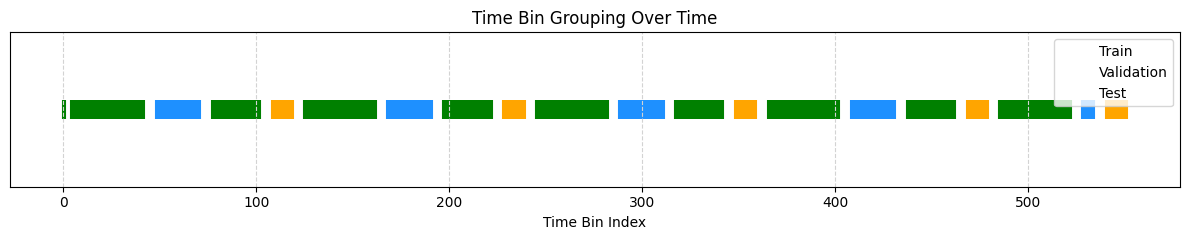

Train bins size: 297
Validation bins size: 103
Test bins size: 60
Train bins percentage: 0.6456521739130435
Validation bins percentage: 0.22391304347826088
Test bins percentage: 0.13043478260869565


In [400]:
train_bins, val_bins, test_bins = assign_time_bins_by_day_cadence(
    positions_links_df,
    window_size=window_size
)

plot_time_bin_split(train_bins, val_bins, test_bins)

print("Train bins size:", len(train_bins))
print("Validation bins size:", len(val_bins))
print("Test bins size:", len(test_bins))

print("Train bins percentage:", len(train_bins) / (len(train_bins) + len(val_bins) + len(test_bins)))
print("Validation bins percentage:", len(val_bins) / (len(train_bins) + len(val_bins) + len(test_bins)))
print("Test bins percentage:", len(test_bins) / (len(train_bins) + len(val_bins) + len(test_bins)))

Found 0 bins assigned to multiple groups: []


In [22]:
# setting a random seed for reproducibility
# (this will make sure that the results are the same every time the code is run even for random values)

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [23]:
from collections import Counter

all_targets = []
for t in train_bins:
    is_active = (targets[t - 1][0] >= 1).float()  # binary labels
    all_targets.extend(is_active.tolist())

counts = Counter(all_targets)
num_neg = counts[0.0]
num_pos = counts[1.0]

pos_weight = num_neg / num_pos
print(f"Suggested pos_weight: {pos_weight:.2f}")

Suggested pos_weight: 155.45


In [24]:
import torch.nn.functional as F
import time
from itertools import product


start_time_train = time.time()

# --- Training Loop ---
losses_total = []
losses_mse = []
losses_presence = []
losses_edge = []
losses_mode = []

for epoch in range(num_epochs):
    model.train()
    loss_sum = 0
    step_count = 0
    mse_total = 0.0
    presence_total = 0.0
    edge_total = 0.0
    mode_total = 0.0
    epoch_start = time.time()

    for t in train_bins:
        x_seq = features[t - window_size:t]
        ei_seq = edge_indices[t - window_size:t]
        ef_seq = edge_features[t - window_size:t]

        if all(ei.size(1) == 0 for ei in ei_seq):
            step_count += 1
            #print('a')
            continue
        
        #print(1)

        z = model.forward_encoder(x_seq, ei_seq, ef_seq)

        future_hour, future_day = bin_context[t]
        time_feat = torch.tensor([[future_hour, future_day]], dtype=torch.float)

        # 1. NODE flow and presence prediction
        node_target = targets[t - 1][0]                     # true node targets
        node_time_feat = time_feat.repeat(num_nodes, 1)     
        node_pred = model.predict_node_counts(z, node_time_feat)
        active_nodes = (node_pred >= 0.3).nonzero(as_tuple=False).flatten()
            
        
        is_active = (node_target >= 1).float()

        presence_loss = F.binary_cross_entropy_with_logits(node_pred, is_active, pos_weight=torch.tensor(20.0))
        mse_loss = F.mse_loss(node_pred, node_target)

        node_loss = mse_loss + 2.0 * presence_loss


        # 2. Last time step NODEs
        df_prev = positions_links_df[positions_links_df["time_bin"] == t - 1]
        last_locations = (
            df_prev.sort_values("merged_datetime")  # make sure it's sorted by time
                .groupby("id_participant")          # group by person
                .tail(1)                            # get last row per person
        )

        # Extract unique last node_ids
        source_nodes = torch.tensor(last_locations["node_id"].unique(), dtype=torch.long)


        # 3. Candidate edges
        source_to_active = list(product(source_nodes.tolist(), active_nodes.tolist()))
        active_to_active = list(product(active_nodes.tolist(), active_nodes.tolist()))
        all_candidate_pairs = list(set(source_to_active + active_to_active))

        candidate_edges = torch.tensor(all_candidate_pairs, dtype=torch.long).T        

        # True edge targets (at time t)
        true_edge_index = targets[t - 1][1]   # from time t
        true_flow = targets[t - 1][2]
        true_mode = targets[t - 1][3]

        true_edge_dict = {tuple(e): i for i, e in enumerate(true_edge_index.T.tolist())} # dictionary for fast lookup

        # True and Negative edge targets
        flow_targets = torch.tensor([
            true_flow[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0.0
            for s, d in candidate_edges.T
        ], dtype=torch.float)

        mode_targets = torch.tensor([
            true_mode[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0
            for s, d in candidate_edges.T
        ], dtype=torch.long)

        # Edge Decoder calls
        

        edge_loss = torch.tensor(0.0)
        mode_loss = torch.tensor(0.0)

        if active_nodes.numel() > 0:
            edge_time_feat = time_feat.repeat(candidate_edges.shape[1], 1)
            edge_flow_pred = model.predict_edge_flow(z, candidate_edges, edge_time_feat)
            mode_logits = model.predict_edge_mode(z, candidate_edges, edge_time_feat)

            edge_loss = F.mse_loss(edge_flow_pred, flow_targets)
            mode_loss = F.cross_entropy(mode_logits, mode_targets)

        total_loss = node_loss + edge_loss + mode_loss


        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss_sum += total_loss.item()
        step_count += 1
        mse_total += mse_loss.item()
        presence_total += presence_loss.item()
        edge_total += edge_loss.item()
        mode_total += mode_loss.item()
    
    avg_loss = loss_sum / step_count
    losses_total.append(avg_loss)
    losses_mse.append(mse_total / step_count)
    losses_presence.append(presence_total / step_count)
    losses_edge.append(edge_total / step_count)
    losses_mode.append(mode_total / step_count)
    print(f"Epoch {epoch + 1}/{num_epochs},\t\tTraining Loss: {avg_loss:.4f},\t\tTime: {time.time() - epoch_start:.2f}s")
    print(f"\t⤷ MSE: {mse_total/step_count:.4f} | Presence BCE: {presence_total/step_count:.4f} | Edge MSE: {edge_total/step_count:.4f} | Mode CE: {mode_total/step_count:.4f}")
    scheduler.step(avg_loss)
    for param_group in optimizer.param_groups:
        print(f"\t⤷ LR: {param_group['lr']:.6f}")

end_time = time.time()
print(f"\nTotal training time: {(end_time - start_time_train):.2f} seconds")



C:\Users\Michele\AppData\Local\Temp\ipykernel_16900\935866414.py:74: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  candidate_edges = torch.tensor(all_candidate_pairs, dtype=torch.long).T


Epoch 1/60,		Training Loss: 1.3958,		Time: 12.22s
	⤷ MSE: 0.1312 | Presence BCE: 0.6214 | Edge MSE: 0.0084 | Mode CE: 0.0134
	⤷ LR: 0.010000
Epoch 2/60,		Training Loss: 1.3741,		Time: 10.39s
	⤷ MSE: 0.1320 | Presence BCE: 0.6186 | Edge MSE: 0.0001 | Mode CE: 0.0047
	⤷ LR: 0.010000
Epoch 3/60,		Training Loss: 1.3732,		Time: 10.26s
	⤷ MSE: 0.1311 | Presence BCE: 0.6187 | Edge MSE: 0.0001 | Mode CE: 0.0046
	⤷ LR: 0.010000
Epoch 4/60,		Training Loss: 1.3725,		Time: 10.46s
	⤷ MSE: 0.1314 | Presence BCE: 0.6183 | Edge MSE: 0.0002 | Mode CE: 0.0044
	⤷ LR: 0.010000
Epoch 5/60,		Training Loss: 1.3716,		Time: 11.07s
	⤷ MSE: 0.1316 | Presence BCE: 0.6179 | Edge MSE: 0.0000 | Mode CE: 0.0042
	⤷ LR: 0.010000
Epoch 6/60,		Training Loss: 1.3735,		Time: 10.38s
	⤷ MSE: 0.1316 | Presence BCE: 0.6177 | Edge MSE: 0.0001 | Mode CE: 0.0064
	⤷ LR: 0.010000
Epoch 7/60,		Training Loss: 1.3725,		Time: 10.02s
	⤷ MSE: 0.1317 | Presence BCE: 0.6177 | Edge MSE: 0.0000 | Mode CE: 0.0054
	⤷ LR: 0.010000
Epoch 8/60,		

In [26]:
loss_dict = {
    "total": np.array(losses_total),
    "mse": np.array(losses_mse),
    "presence": np.array(losses_presence),
    "edge": np.array(losses_edge),
    "mode": np.array(losses_mode),
}

np.save("D:/Desktop/MSc Thesis/scripts/losses/loss_13.npy", loss_dict)

In [133]:
loss_plot_config = {
    "mse": {
        "label": "Node MSE",
        "color": "green",
        "linestyle": "-",
        "linewidth": 1

    },
    "presence": {
        "label": "Node Presence BCE",
        "color": "dodgerblue",
        "linestyle": "-",
        "linewidth": 1
    },
    "edge": {
        "label": "Edge Count MSE",
        "color": "deeppink",
        "linestyle": "-",
        "linewidth": 1
    },
    "mode": {
        "label": "Edge Transport CE",
        "color": "orange",
        "linestyle": "-",
        "linewidth": 1
    },
    "total": {
        "label": "Total Loss",
        "color": "black",
        "linestyle": ":",
        "linewidth": 1.6
    }
}

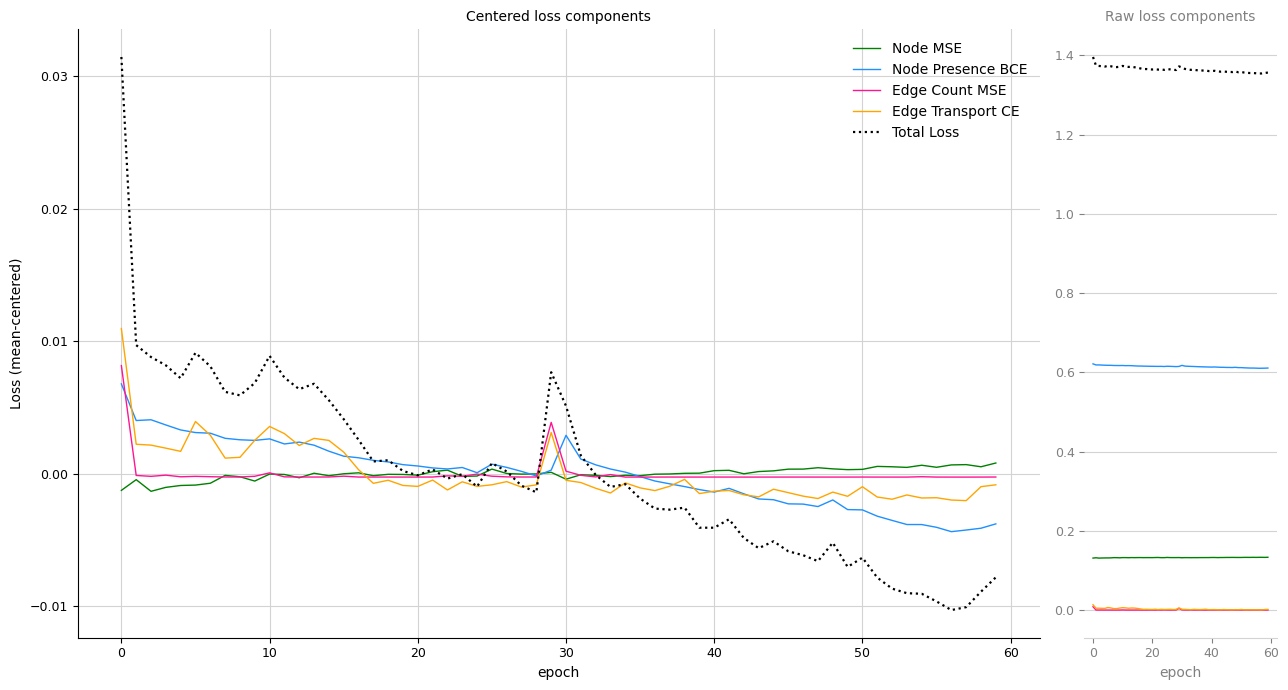

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Centered losses
losses_centered_total = np.array(losses_total) - np.mean(losses_total)
losses_centered_mse = np.array(losses_mse) - np.mean(losses_mse)
losses_centered_presence = np.array(losses_presence) - np.mean(losses_presence)
losses_centered_edge = np.array(losses_edge) - np.mean(losses_edge)
losses_centered_mode = np.array(losses_mode) - np.mean(losses_mode)

# Create a 1x2 subplot layout
fig, axs = plt.subplots(
    1, 2,
    figsize=(13, 7),
    gridspec_kw={'width_ratios': [3, 0.6]}
)
# ── Left: Centered Losses ──

axs[0].plot(losses_centered_mse, **loss_plot_config["mse"])
axs[0].plot(losses_centered_presence, **loss_plot_config["presence"])
axs[0].plot(losses_centered_edge, **loss_plot_config["edge"])
axs[0].plot(losses_centered_mode, **loss_plot_config["mode"])
axs[0].plot(losses_centered_total, **loss_plot_config["total"])
axs[0].set_xlabel("epoch", fontsize=10)
axs[0].set_ylabel("Loss (mean-centered)", fontsize=10)
axs[0].set_title("Centered loss components", fontsize=10)
axs[0].legend(frameon=False)
axs[0].grid(True, color='lightgray')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].tick_params(labelsize=9)

# ── Right: Raw Losses ──
alpha = 1
axs[1].plot(losses_total, **loss_plot_config["total"], alpha=alpha)
axs[1].plot(losses_mse, **loss_plot_config["mse"])
axs[1].plot(losses_presence, **loss_plot_config["presence"])
axs[1].plot(losses_edge, **loss_plot_config["edge"])
axs[1].plot(losses_mode, **loss_plot_config["mode"])


axs[1].set_xlabel("epoch", color='gray', fontsize=10)
axs[1].set_title("Raw loss components", color='gray', fontsize=10)
#axs[1].legend()
axs[1].grid(axis='y', color='lightgray')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(labelsize=9, colors='gray' )
axs[1].spines['bottom'].set_color('lightgray')


plt.tight_layout()
plt.show()


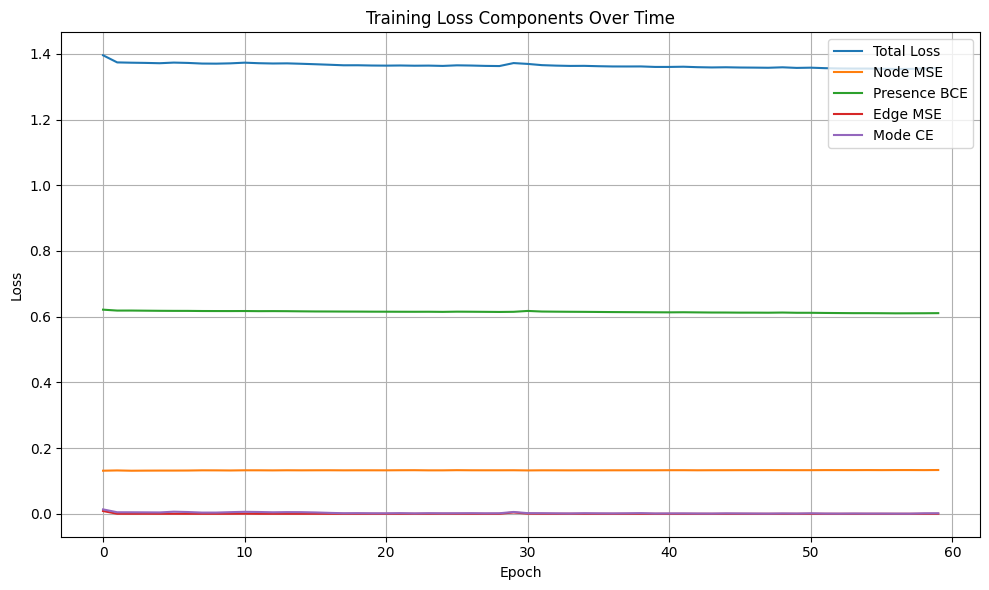

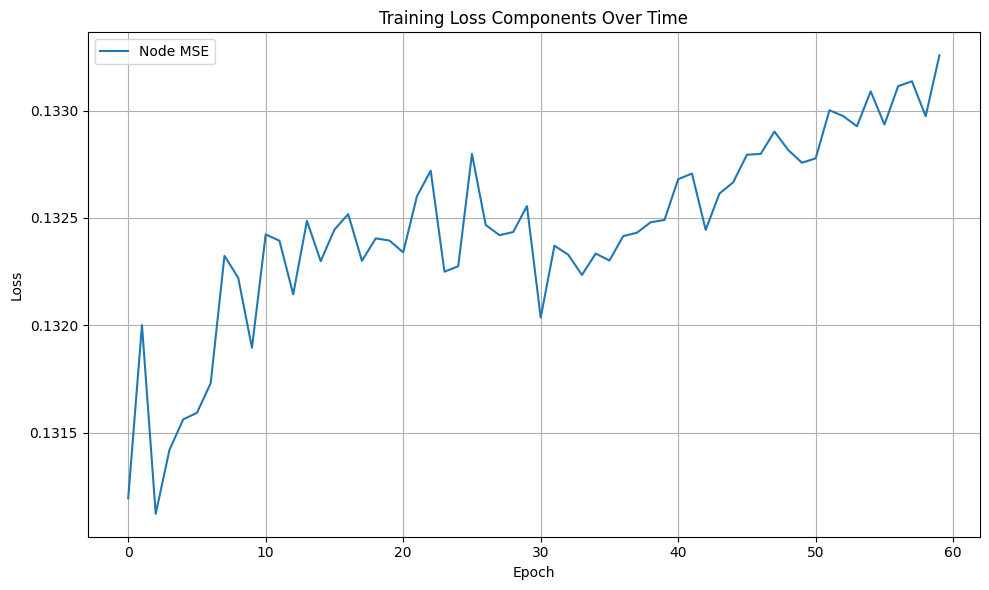

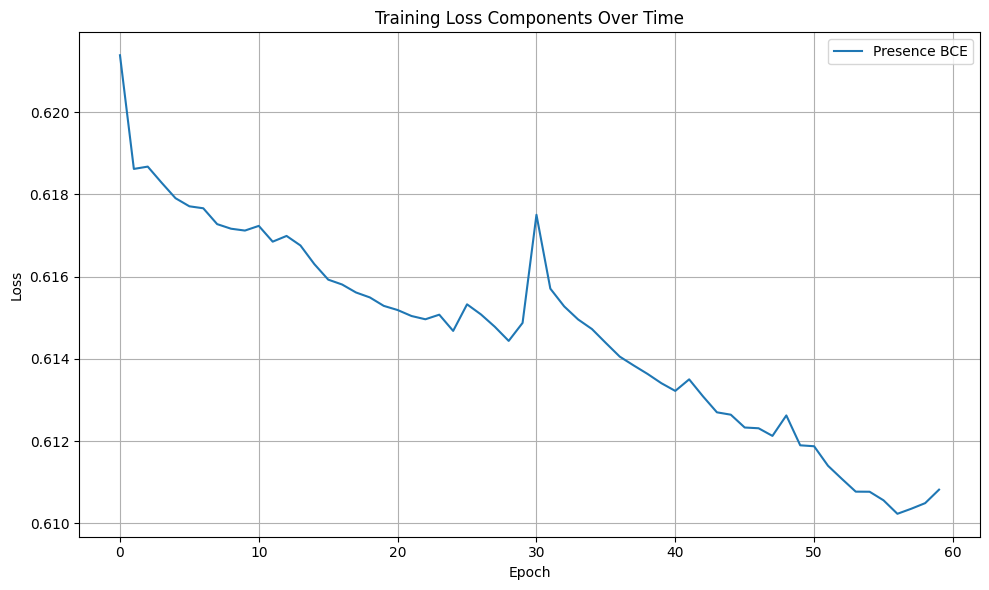

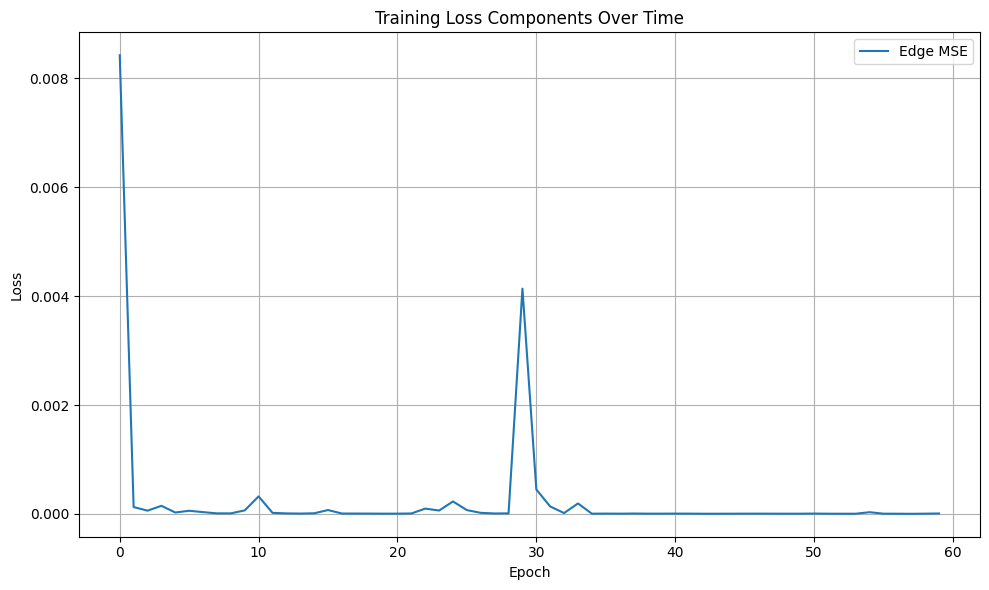

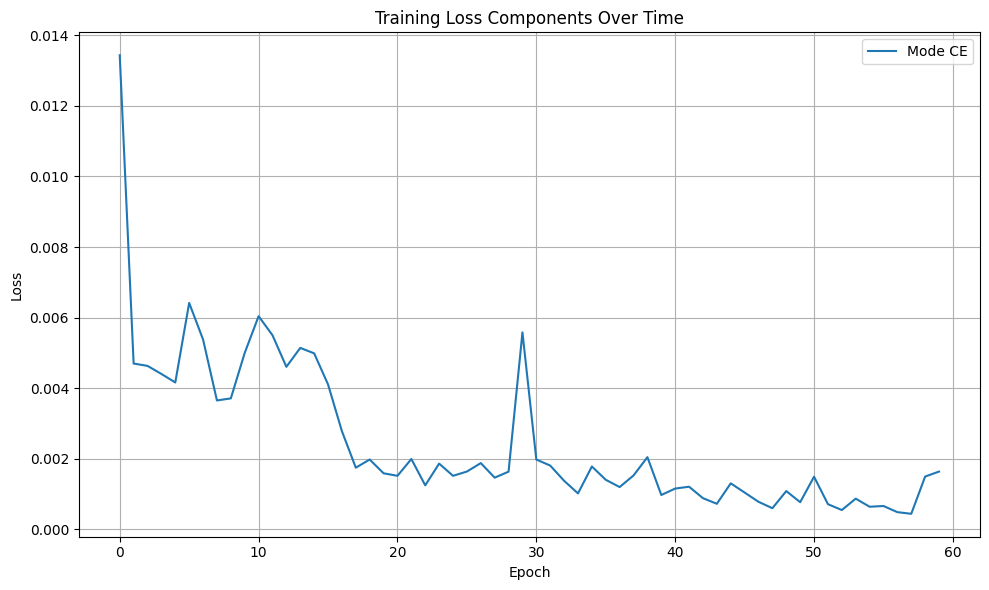

<Figure size 1000x600 with 0 Axes>

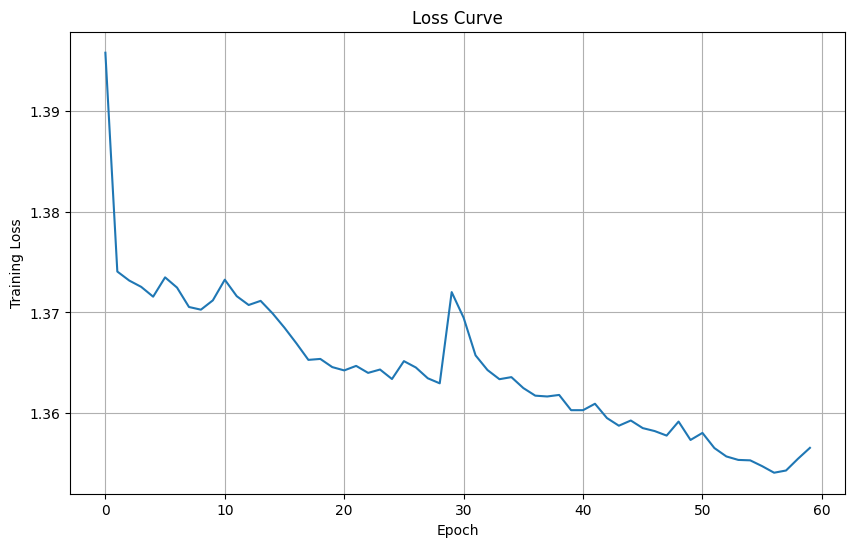

In [79]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses_total, label='Total Loss')
plt.plot(losses_mse, label='Node MSE')
plt.plot(losses_presence, label='Presence BCE')
plt.plot(losses_edge, label='Edge MSE')
plt.plot(losses_mode, label='Mode CE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(losses_mse, label='Node MSE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(losses_presence, label='Presence BCE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(losses_edge, label='Edge MSE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(losses_mode, label='Mode CE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(losses_total)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()



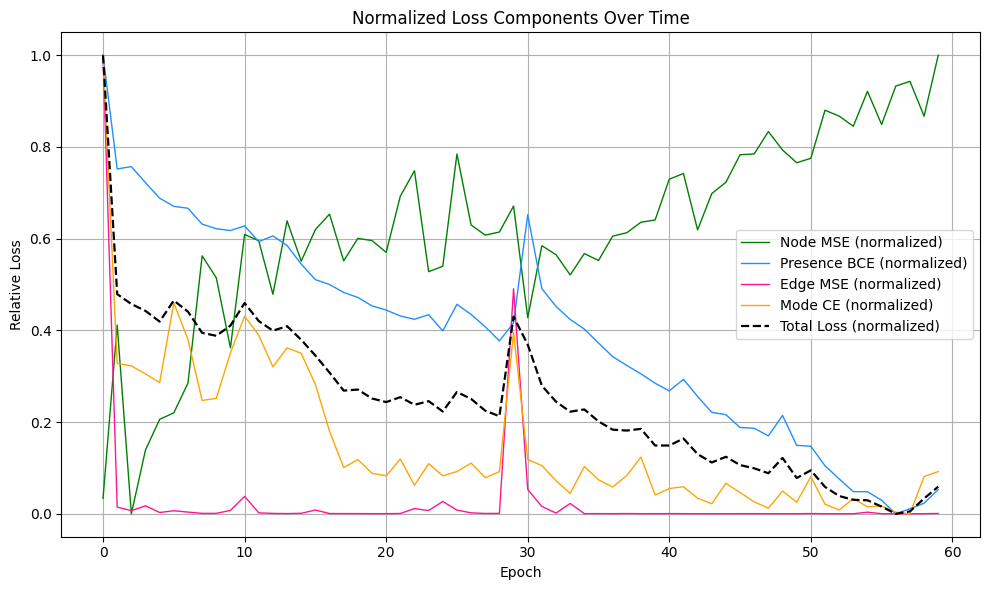

In [74]:
norm_losses_total = (np.array(losses_total) - min(losses_total))    / (max(losses_total) - min(losses_total))
norm_losses_mse = (np.array(losses_mse) - min(losses_mse))          / (max(losses_mse) - min(losses_mse))
norm_losses_presence = (np.array(losses_presence) - min(losses_presence)) / (max(losses_presence) - min(losses_presence))
norm_losses_edge = (np.array(losses_edge) - min(losses_edge)) / (max(losses_edge) - min(losses_edge))
norm_losses_mode = (np.array(losses_mode) - min(losses_mode)) / (max(losses_mode) - min(losses_mode))

plt.figure(figsize=(10, 6))

plt.plot(norm_losses_mse, label="Node MSE (normalized)", linewidth=1, color='green')
plt.plot(norm_losses_presence, label="Presence BCE (normalized)", linewidth=1, color='dodgerblue')
plt.plot(norm_losses_edge, label="Edge MSE (normalized)", linewidth=1, color='deeppink')
plt.plot(norm_losses_mode, label="Mode CE (normalized)", linewidth=1, color='orange')
plt.plot(norm_losses_total, label="Total Loss (normalized)", linestyle='--', color='black', linewidth=1.6)
plt.xlabel("Epoch")
plt.ylabel("Relative Loss")
plt.title("Normalized Loss Components Over Time")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [471]:
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
from scipy.stats import pearsonr

def evaluate_multitask(model, features, edge_indices, edge_features, targets, test_bins, bin_context, threshold=0.3):
    model.eval()
    node_true = []
    node_pred = []
    edge_true = []
    edge_pred = []
    mode_true = []
    mode_pred = []
    node_presence_true = []
    node_presence_pred = []

    with torch.no_grad():
        for t in test_bins:
            x_seq = features[t - window_size:t]
            ei_seq = edge_indices[t - window_size:t]
            ef_seq = edge_features[t - window_size:t]

            if all(ei.size(1) == 0 for ei in ei_seq):
                continue

            z = model.forward_encoder(x_seq, ei_seq, ef_seq)

            # Time context
            future_hour, future_day = bin_context[t]
            time_feat = torch.tensor([[future_hour, future_day]], dtype=torch.float)
            num_nodes = features[0].shape[0]
            node_time_feat = time_feat.repeat(num_nodes, 1)

            # ─── NODE PREDICTION ────────────────────────────────
            node_target = targets[t - 1][0]
            node_pred_t = model.predict_node_counts(z, node_time_feat)

            node_true.extend(node_target.cpu().numpy())
            node_pred.extend(node_pred_t.cpu().numpy())

            is_active = (node_target >= 1).float().cpu().numpy()
            predicted_active = (node_pred_t >= threshold).float().cpu().numpy()
            node_presence_true.extend(is_active)
            node_presence_pred.extend(predicted_active)

            # ─── EDGE PREDICTION ────────────────────────────────
            active_nodes = (node_pred_t >= threshold).nonzero(as_tuple=False).flatten()
            if active_nodes.numel() == 0:
                continue

            df_prev = positions_links_df[positions_links_df["time_bin"] == t - 1]
            last_positions = (
                df_prev.sort_values("merged_datetime")
                       .groupby("id_participant")
                       .tail(1)
            )
            source_nodes = torch.tensor(last_positions["node_id"].unique(), dtype=torch.long)
            if source_nodes.numel() == 0:
                continue

            from itertools import product
            source_to_active = list(product(source_nodes.tolist(), active_nodes.tolist()))
            active_to_active = list(product(active_nodes.tolist(), active_nodes.tolist()))
            all_candidate_pairs = list(set(source_to_active + active_to_active))
            candidate_edges = torch.tensor(all_candidate_pairs, dtype=torch.long).T

            edge_time_feat = time_feat.repeat(candidate_edges.shape[1], 1)

            true_edge_index = targets[t - 1][1]
            true_flow = targets[t - 1][2]
            true_mode = targets[t - 1][3]
            true_edge_dict = {tuple(e): i for i, e in enumerate(true_edge_index.T.tolist())}

            flow_targets = torch.tensor([
                true_flow[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0.0
                for s, d in candidate_edges.T
            ], dtype=torch.float)

            mode_targets = torch.tensor([
                true_mode[true_edge_dict[(int(s), int(d))]] if (int(s), int(d)) in true_edge_dict else 0
                for s, d in candidate_edges.T
            ], dtype=torch.long)

            edge_pred_t = model.predict_edge_flow(z, candidate_edges, edge_time_feat)
            mode_pred_t = model.predict_edge_mode(z, candidate_edges, edge_time_feat)
            predicted_classes = mode_pred_t.argmax(dim=1)

            edge_true.extend(flow_targets.cpu().numpy())
            edge_pred.extend(edge_pred_t.cpu().numpy())
            mode_true.extend(mode_targets.cpu().numpy())
            mode_pred.extend(predicted_classes.cpu().numpy())

    # ─── METRICS ─────────────────────────────────────────────

    node_true = np.array(node_true)
    node_pred = np.array(node_pred)

    true_binary = np.array(node_presence_true)
    pred_binary = np.array(node_presence_pred)

    node_mse = mean_squared_error(node_true, node_pred)
    edge_mse = mean_squared_error(edge_true, edge_pred)
    mode_acc = accuracy_score(mode_true, mode_pred)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    f1 = f1_score(true_binary, pred_binary, zero_division=0)
    accuracy = accuracy_score(true_binary, pred_binary)
    correlation = pearsonr(node_true, node_pred)[0]

    print("\nEvaluation Results:")
    print(f"  ▪ Node Count MSE         : {node_mse:.4f}")
    print(f"  ▪ Edge Flow MSE          : {edge_mse:.4f}")
    print(f"  ▪ Transport Mode Accuracy: {mode_acc:.4f}")
    print(f"  ▪ Node Presence Accuracy : {accuracy:.4f}")
    print(f"  ▪ Node Precision         : {precision:.4f}")
    print(f"  ▪ Node Recall            : {recall:.4f}")
    print(f"  ▪ Node F1 Score          : {f1:.4f}")
    print(f"  ▪ Node Pearson Corr.     : {correlation:.4f}")


In [472]:
evaluate_multitask(model, features, edge_indices, edge_features, targets, test_bins, bin_context)


Evaluation Results:
  ▪ Node Count MSE         : 0.1295
  ▪ Edge Flow MSE          : 0.0000
  ▪ Transport Mode Accuracy: 0.9997
  ▪ Node Presence Accuracy : 0.9942
  ▪ Node Precision         : 0.4248
  ▪ Node Recall            : 0.1782
  ▪ Node F1 Score          : 0.2511
  ▪ Node Pearson Corr.     : 0.5583
